# tmp — mar24

**Motivation**: scratch notebook <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from figures.fighelper import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

## Speed up Poisson rsample

In [2]:
from torch.distributions import Exponential
from base.distributions import Poisson

log_rates = torch.randn(200, 1000) * 20
log_rates = log_rates.cuda()

In [3]:
%timeit dist = Poisson(log_rates, temp=0.5)

23.5 µs ± 1.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [4]:
%timeit dist = Poisson(log_rates, temp=0.5, n_exp=271)

21.4 µs ± 98.2 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [7]:
dist = Poisson(log_rates, temp=0.5)
dist.n_exp

263

In [9]:
%%time

d = Exponential(dist.rates)
x = d.rsample((1600,))

CPU times: user 0 ns, sys: 3.83 ms, total: 3.83 ms
Wall time: 2.86 ms


In [12]:
%timeit d.rsample((30,))

42.6 µs ± 1.03 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [10]:
%timeit d.rsample((300,))

872 µs ± 175 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [11]:
%timeit d.rsample((1600,))

4.6 ms ± 920 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [15]:
%%time

spks = dist.rsample()

CPU times: user 1.95 ms, sys: 0 ns, total: 1.95 ms
Wall time: 1.24 ms


In [16]:
from torch import nn
from torch.nn import functional as F
from _tmp.gapvae import prepare_stuff, iteration, validate
from _tmp.plotters import plot_latent_space, plot_latent_scatter

n_latents = 1000
weight_norm = True

batch_size = 200
epochs = 300

pvae, optim, optim_schedule, trn, vld, device, kws_iter = prepare_stuff(
    model='pois',
    device_idx=0,
    n_latents=n_latents,
    weight_norm=weight_norm,
    max_grad_norm=500,
    batch_size=batch_size,
    epochs=epochs,
    lr=1e-3,
    beta=1.0,
)

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|  PoissonVAE |  8.9 Mil   |
|     ---     |    ---     |
|     enc     |  6.6 Mil   |
|    fc_enc   |   33.0 K   |
|     dec     |  1.2 Mil   |
|    fc_dec   |  1.0 Mil   |
+-------------+------------+

In [17]:
x, _ = next(iter(vld))
x = x.to(device)

In [24]:
self = pvae

In [25]:
%%time

log_dr = self.fc_enc(self.enc(x))
log_r = self.log_rates.expand(len(x), -1)
dist = Poisson(
    log_rates=log_r + log_dr,
    temp=self.temp,
    n_exp=3000,
)

CPU times: user 34.4 ms, sys: 3.09 ms, total: 37.5 ms
Wall time: 36.1 ms


In [26]:
%%time

spks = dist.rsample()
# Decode
h = self.fc_dec(spks)
h = h.view(*self.shape)
x_recon = self.dec(h)

CPU times: user 6.99 ms, sys: 3.43 ms, total: 10.4 ms
Wall time: 9.22 ms


In [27]:
out = {
    'log_r': log_r,
    'log_dr': log_dr,
    'spks': spks,
    'x_recon': x_recon,
}

In [28]:
%%time

loss_dict = pvae.compute_loss(x, **out)
loss = loss_dict['tot'] / len(x)

CPU times: user 2.09 ms, sys: 1.18 ms, total: 3.27 ms
Wall time: 2 ms


In [29]:
%%time

loss.backward()

CPU times: user 39.1 ms, sys: 35.5 ms, total: 74.6 ms
Wall time: 72.7 ms


In [110]:
%timeit sp_stats.poisson(np.exp(5.3)).ppf(1.0 - 1e-4)

286 µs ± 2.47 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [119]:
sp_stats.poisson(np.exp(5.3)).ppf(1.0 - 1e-5)

263.0

In [114]:
1 - 1e-3

0.999

In [40]:
%%time

out = pvae(x)

CPU times: user 412 ms, sys: 75.6 ms, total: 488 ms
Wall time: 486 ms


In [42]:
%%time

loss_dict = pvae.compute_loss(x, **out)
loss = loss_dict['tot'] / len(x)

CPU times: user 9.08 ms, sys: 12 ms, total: 21.1 ms
Wall time: 19.7 ms


In [43]:
%%time

loss.backward()

CPU times: user 433 ms, sys: 80.3 ms, total: 513 ms
Wall time: 612 ms


In [48]:
%%time

grad_norm = nn.utils.clip_grad_norm_(
    parameters=get_params(pvae),
    max_norm=500,
).item()

CPU times: user 7.13 ms, sys: 23.7 ms, total: 30.8 ms
Wall time: 205 ms


In [49]:
%%time

optim.step()
optim_schedule.step()

CPU times: user 20.9 ms, sys: 8.4 ms, total: 29.3 ms
Wall time: 28.7 ms


In [50]:
60000 / 200

300.0

In [52]:
300 * 1.5 / 60

7.5

In [53]:
pvae, optim, optim_schedule, trn, vld, device, kws_iter = prepare_stuff(
    model='pvaest',
    device_idx=0,
    n_latents=n_latents,
    weight_norm=weight_norm,
    max_grad_norm=500,
    batch_size=batch_size,
    epochs=epochs,
    lr=1e-3,
    beta=1.0,
)

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
| PoissonVAEST |  8.9 Mil   |
|     ---      |    ---     |
|     enc      |  6.6 Mil   |
|     dec      |  2.3 Mil   |
+--------------+------------+

In [54]:
%%time

out = pvae(x)

CPU times: user 5.13 ms, sys: 26.6 ms, total: 31.7 ms
Wall time: 31.2 ms


$486 \rightarrow 31.2$

In [55]:
%%time

loss_dict = pvae.compute_loss(x, **out)
loss = loss_dict['tot'] / len(x)

CPU times: user 48 µs, sys: 11.8 ms, total: 11.8 ms
Wall time: 10.1 ms


$19.7 \rightarrow 10.1$

In [57]:
%%time

loss.backward()

CPU times: user 18.4 ms, sys: 11.9 ms, total: 30.3 ms
Wall time: 29.7 ms


$612 \rightarrow 29.7$

In [59]:
%%time

grad_norm = nn.utils.clip_grad_norm_(
    parameters=get_params(pvae),
    max_norm=500,
).item()

CPU times: user 733 µs, sys: 15.6 ms, total: 16.3 ms
Wall time: 113 ms


$205 \rightarrow 113$

In [60]:
%%time

optim.step()
optim_schedule.step()

CPU times: user 10.7 ms, sys: 3.72 ms, total: 14.4 ms
Wall time: 13.3 ms


$28.7 \rightarrow 13.3$

## Gaussian CDF (closed form)

$E_{\mu, \sigma^2}[\Phi(X)] = \Phi(\frac{\mu}{\sqrt{1 + \sigma^2}})$

In [2]:
def Phi(x):
    return (1 + torch.erf(x.div(np.sqrt(2)))).mul(0.5)

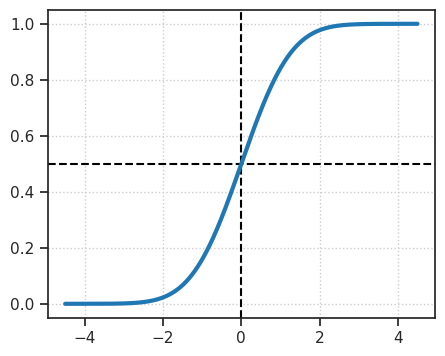

In [3]:
x = torch.linspace(-4.5, 4.5, 1000)

fig, ax = create_figure(1, 1, (5, 4))
ax.plot(x, Phi(x), lw=3, zorder=3)
ax.axvline(0.0, color='k', ls='--', zorder=1)
ax.axhline(0.5, color='k', ls='--', zorder=1)
ax.grid();

In [4]:
mu, sigma = -20, 5
dist = sp_stats.norm(mu, sigma)

In [5]:
x = torch.linspace(-70, 70, 10000)
pdf = dist.pdf(to_np(x))
y = pdf * to_np(Phi(x))

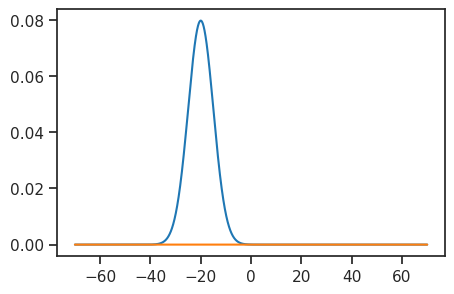

In [6]:
plt.plot(x, pdf)
plt.plot(x, y)

In [7]:
y.sum()

0.003131809570344765

In [8]:
def approximate_integral(mu, sigma, a, b, n):
    dist = sp_stats.norm(mu, sigma)
    
    x = torch.linspace(a, b, n+1)
    fx = dist.pdf(to_np(x))
    gx = to_np(Phi(x))
    fgx = fx * gx
    
    h = (b - a) / n
    integral = h * (0.5*fgx[0] + np.sum(fgx[1:-1]) + 0.5*fgx[-1])
    return integral

In [10]:
mu, sigma = -4, 7

val = approximate_integral(mu, sigma, -1000, 1000, 10000000)
theo = Phi(torch.tensor(mu / np.sqrt(1 + sigma**2)))

val, theo.item(), val - theo.item()

(0.2858026069743507, 0.2858038224766658, -1.215502315077277e-06)

In [11]:
x = torch.randn(10, 10, requires_grad=True)

out = torch.sum(x, dim=1)
print(out.grad_fn)

<SumBackward1 object at 0x7fda0273e0e0>

In [12]:
out = torch.argmax(x, dim=1)
print(out.grad_fn)

None

In [14]:
out = torch.erf(x)
print(out.grad_fn)

<ErfBackward0 object at 0x7fd91235ba00>

In [15]:
out = x < 1.0
print(out.grad_fn)

None

## Poisson rsample

In [2]:
from base.distributions import Poisson
from torch.distributions import Exponential
from torch.nn import functional as F

In [3]:
lmbd = torch.tensor(np.array(
    [[1.0, 10.0, 20.0],
     [50.0, 100.0, 300.0]],
))

temp = 0.0
dist = Poisson(
    log_rates=torch.log(lmbd),
    temp=temp,
    n_exp='infer',
)

In [4]:
samples = []
samples_torch = []

for _ in tqdm(range(100000)):
    samples.append(dist.rsample())
    samples_torch.append(dist.sample())

samples = torch.stack(samples)
samples_torch = torch.stack(samples_torch)

100%|████████████████████████████████| 100000/100000 [00:06<00:00, 15641.47it/s]


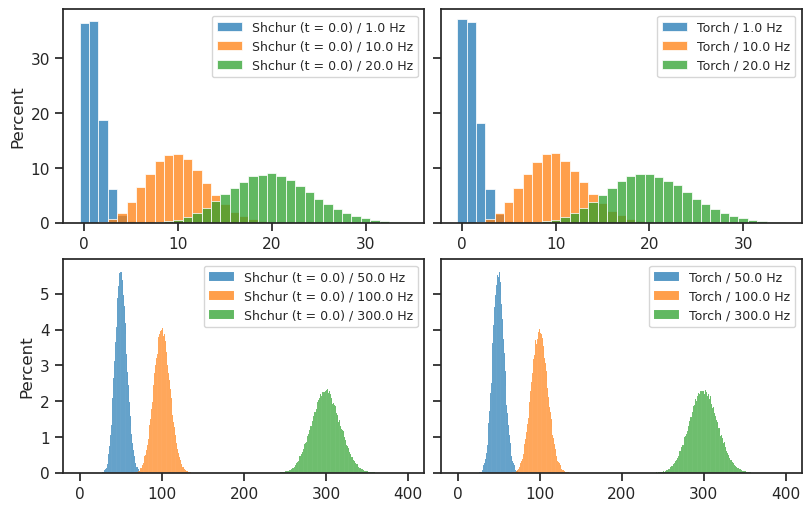

In [5]:
kws = dict(stat='percent')
fig, axes = create_figure(2, 2, (8, 5), sharey='row', layout='constrained')

for j, nbins in enumerate([35, 400]):
    kws['bins'] = np.linspace(0, nbins, nbins+1) - 0.5
    for i in range(3):
        
        # Schur (rsample)
        x2p = to_np(samples[:, j, i])
        lbl = f"Shchur (t = {temp:0.1f}) / {lmbd[j, i].item():0.1f} Hz"
        sns.histplot(x2p, color=f"C{i}", label=lbl, ax=axes[j, 0], **kws)
        
        # PyTorch (sample)
        x2p = to_np(samples_torch[:, j, i])
        lbl = f"Torch / {lmbd[j, i].item():0.1f} Hz"
        sns.histplot(x2p, color=f"C{i}", label=lbl, ax=axes[j, 1], **kws)

for ax in axes.flat:
    ax.legend(fontsize=9)

plt.show()

In [7]:
temp = 0.5

dist_relaxed = Poisson(
    log_rates=torch.log(lmbd),
    temp=temp,
    n_exp='infer',
)

In [8]:
samples_relaxed = []

for _ in tqdm(range(100000)):
    samples_relaxed.append(dist_relaxed.rsample())

samples_relaxed = torch.stack(samples_relaxed)

100%|████████████████████████████████| 100000/100000 [00:06<00:00, 14394.92it/s]


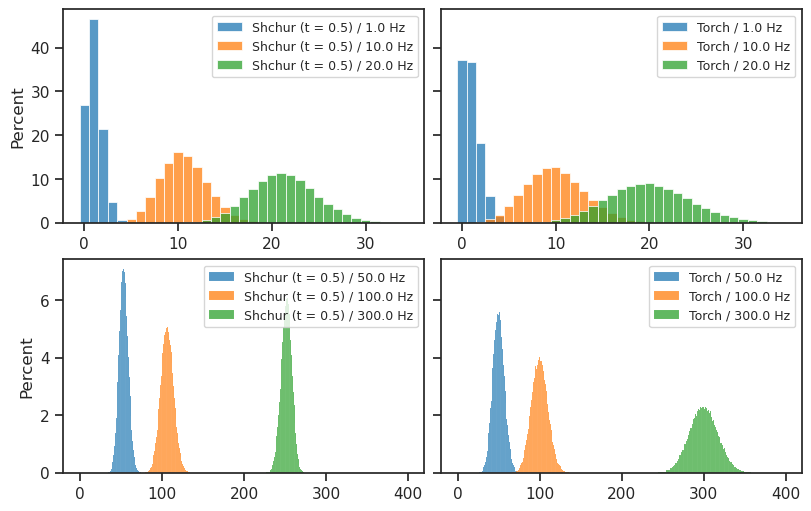

In [9]:
kws = dict(stat='percent')
fig, axes = create_figure(2, 2, (8, 5), sharey='row', layout='constrained')

for j, nbins in enumerate([35, 400]):
    kws['bins'] = np.linspace(0, nbins, nbins+1) - 0.5
    for i in range(3):
        
        # Schur (rsample)
        x2p = to_np(samples_relaxed[:, j, i])
        lbl = f"Shchur (t = {temp:0.1f}) / {lmbd[j, i].item():0.1f} Hz"
        sns.histplot(x2p, color=f"C{i}", label=lbl, ax=axes[j, 0], **kws)
        
        # PyTorch (sample)
        x2p = to_np(samples_torch[:, j, i])
        lbl = f"Torch / {lmbd[j, i].item():0.1f} Hz"
        sns.histplot(x2p, color=f"C{i}", label=lbl, ax=axes[j, 1], **kws)

for ax in axes.flat:
    ax.legend(fontsize=9)

plt.show()

## Verify ```softclamp_upper()```

In [10]:
def softclamp_upper(x: torch.Tensor, c: float):
	return c - F.softplus(c - x)

In [11]:
x = torch.linspace(-13, 13, 100)
c = 5
x_clamped = softclamp_upper(x, c)

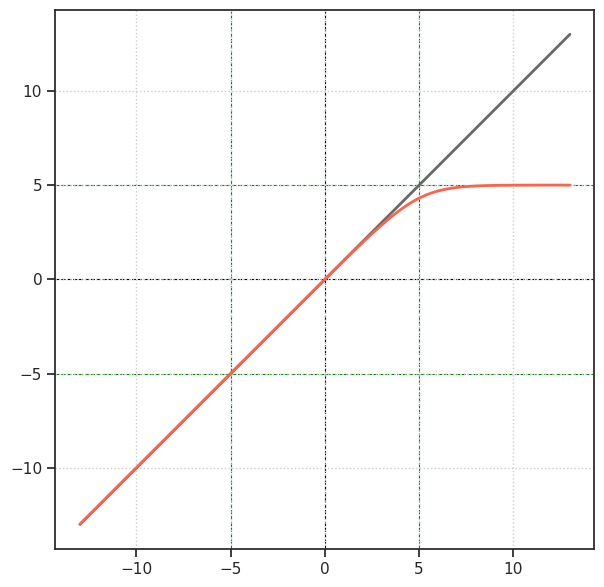

In [12]:
fig, ax = create_figure(1, 1, (7, 7))

ax.plot(x, x, color='dimgrey', lw=2)
ax.plot(x, x_clamped, color='tomato', lw=2)

ax.axvline(c, color='g', ls='--', lw=0.8, zorder=0)
ax.axhline(c, color='g', ls='--', lw=0.8, zorder=0)
ax.axvline(-c, color='g', ls='--', lw=0.8, zorder=0)
ax.axhline(-c, color='g', ls='--', lw=0.8, zorder=0)

ax.axvline(0, color='k', ls='--', lw=0.8, zorder=0)
ax.axhline(0, color='k', ls='--', lw=0.8, zorder=0)

ax_square(ax)
ax.grid()
plt.show()

In [13]:
np.exp(5.3)

200.33680997479166

In [29]:
lmbd = torch.tensor([10.0])

dist = Exponential(lmbd)
x = dist.rsample((20,))
times = torch.cumsum(x, dim=0)

x.shape, times.shape

(torch.Size([20, 1]), torch.Size([20, 1]))

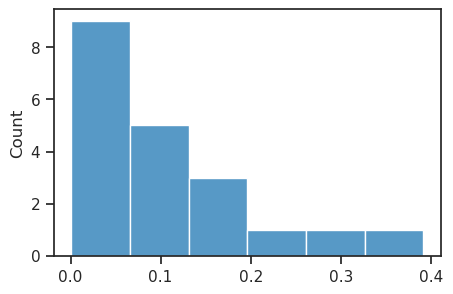

In [30]:
sns.histplot(to_np(x).ravel());

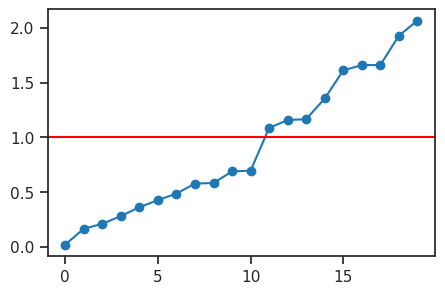

In [31]:
plt.plot(to_np(times).ravel(), marker='o')
plt.axhline(1.0, color='r');

In [32]:
indicator = times < 1.0
indicator.sum(0)

tensor([11])

In [33]:
lmbd = torch.tensor([10.0])

dist = Exponential(lmbd)
x = dist.rsample((200000,))
times = torch.cumsum(x, dim=0)

x.shape, times.shape

(torch.Size([200000, 1]), torch.Size([200000, 1]))

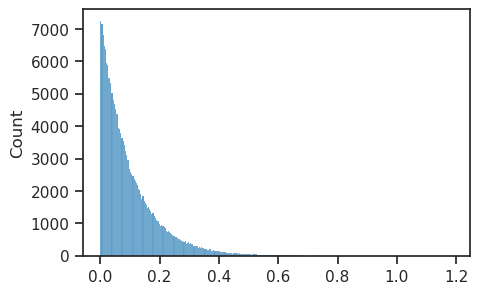

In [34]:
sns.histplot(to_np(x).ravel());

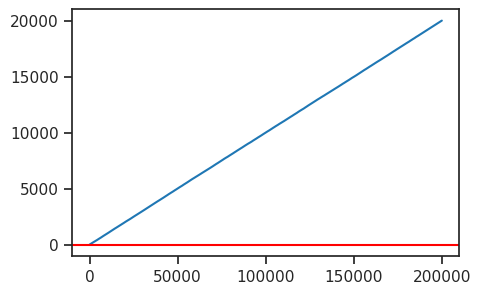

In [37]:
plt.plot(to_np(times).ravel())
plt.axhline(1.0, color='r');

## Normal dist CDF: $\Phi(X)$

In [39]:
from utils.generic import *

rv = sp_stats.norm()
x = np.linspace(-6, 6, 100)
y = rv.cdf(x)

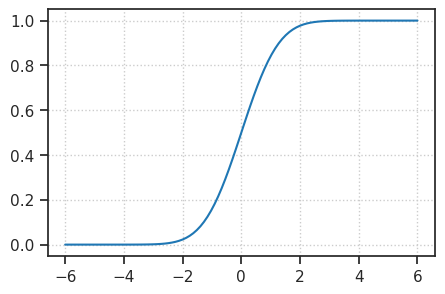

In [40]:
fig, ax = create_figure()
ax.plot(x, y)
ax.grid();

## Continuous Bernoulli

In [42]:
from torch.distributions.continuous_bernoulli import ContinuousBernoulli as CB
from torch.distributions.bernoulli import Bernoulli as B

In [43]:
m = CB(torch.tensor([0.01, 0.3, 0.5, 0.9, 0.99]))
m.sample()

tensor([0.5255, 0.2512, 0.2812, 0.4422, 0.9536])

In [44]:
samples = []
for i in range(10000):
    samples.append(m.rsample())
samples = to_np(torch.stack(samples))

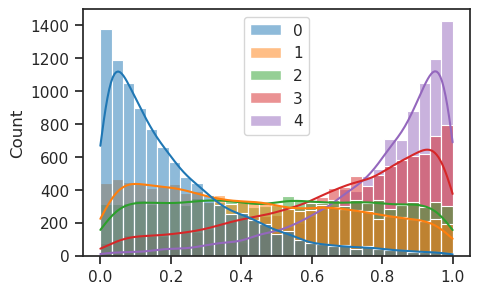

In [45]:
sns.histplot(samples, kde=True);

In [46]:
m = B(torch.tensor([0.01, 0.3, 0.5, 0.9, 0.99]))
m.sample()

tensor([0., 0., 0., 1., 1.])

### Download ImageNet

In [2]:
import torchvision
from torchvision.transforms import v2
from torch.utils.data import DataLoader

npix = 256
batch_size = 128
device = torch.device('cuda:1')

root = pjoin(os.environ['HOME'], 'Datasets', 'ImageNet')
transform = torchvision.transforms.Compose([
    # v2.RandomResizedCrop(size=(32, 32), antialias=True),
    # torchvision.transforms.RandomCrop(32),
    torchvision.transforms.RandomCrop(npix),
    torchvision.transforms.Grayscale(),
    torchvision.transforms.ToTensor(),
])
kws = dict(root=root, transform=transform)

trn = torchvision.datasets.ImageNet(split='train', **kws)
vld = torchvision.datasets.ImageNet(split='val', **kws)

trn = DataLoader(dataset=trn, batch_size=batch_size, shuffle=True)
vld = DataLoader(dataset=vld, batch_size=batch_size, shuffle=False)

In [3]:
len(vld.dataset)

50000

In [4]:
x, y = vld.dataset[5]
x.shape

torch.Size([1, 256, 256])

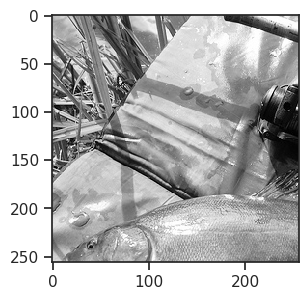

In [5]:
plt.imshow(to_np(x)[0], cmap='Greys_r');

In [46]:
x, y = next(iter(vld))
x.shape

torch.Size([128, 1, 256, 256])

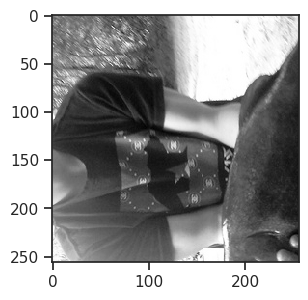

In [47]:
plt.imshow(to_np(x[29, 0]), cmap='Greys_r');

In [48]:
from torch.nn import functional as F

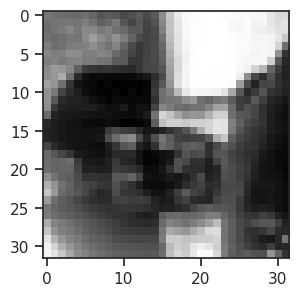

In [57]:
x_down = F.interpolate(x, size=(32, 32), mode='bilinear', antialias=True)
plt.imshow(to_np(x_down[29, 0]), cmap='Greys_r');

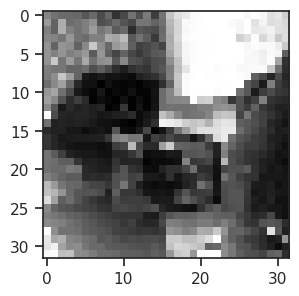

In [58]:
x_down = F.interpolate(x, size=(32, 32), mode='nearest')
plt.imshow(to_np(x_down[29, 0]), cmap='Greys_r');

## FFT

In [21]:
def do_prep_stuff(npix):
    freq = np.fft.fftfreq(npix) * npix
    freq = np.meshgrid(freq, freq)
    freq_norm = np.sqrt(freq[0]**2 + freq[1]**2)

    bins = np.arange(0.5, npix//2 + 1, 1.0)
    kvals = 0.5 * (bins[1:] + bins[:-1])

    return freq_norm, kvals, bins


def do_fft(x):
    x_ft = torch.fft.fft2(x.cuda()).squeeze()
    phase = torch.angle(x_ft)
    amplitude = torch.abs(x_ft)
    power = to_np(amplitude ** 2)

    freq_norm, kvals, bins = do_prep_stuff(x.size(-1))

    psd = np.zeros((len(x), len(kvals)))
    for i in range(len(x)):
        p, _, _ = sp_stats.binned_statistic(
            x=freq_norm.ravel(),
            values=power[i].ravel(),
            statistic='mean',
            bins=bins,
        )
        p *= np.pi * (bins[1:]**2 - bins[:-1]**2)
        psd[i] = p
    return psd

In [18]:
psd = []

i = 0
_iter = iter(vld)

while i < len(vld):
    try:
        x, _ = next(_iter)
        psd.append(do_fft(x.cuda()))
    except (ValueError, StopIteration):
        pass
    i += 1

psd = np.concatenate(psd)
psd.shape

(27008, 128)

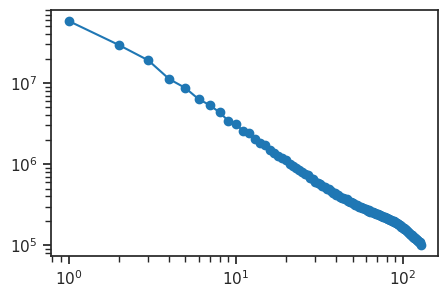

In [22]:
kvals = do_prep_stuff(npix)[1]

plt.loglog(kvals, psd.mean(0), marker='o');

In [25]:
lin_reg = sp_stats.linregress(x=np.log(kvals), y=np.log(psd.mean(0)))
lin_reg

LinregressResult(slope=-1.2878074899958558, intercept=17.849229204859878, rvalue=-0.9968301245966524, pvalue=2.184736106425082e-140, stderr=0.009156640760174712, intercept_stderr=0.036528540012791266)

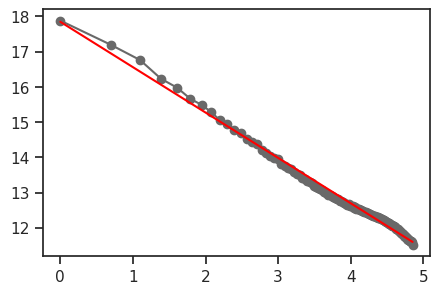

In [31]:
plt.plot(np.log(kvals), np.log(psd.mean(0)), color='dimgrey', marker='o')

x = np.linspace(0, np.max(np.log(kvals)), 100)
y = x * lin_reg.slope + lin_reg.intercept
plt.plot(x, y, color='r')
plt.show()

## Whitening / Contrast Normalization

Correct order:
1. Whitening
2. Local Contrast Normalization (LCN)
3. z score

In [60]:
whitener = Whitening((256, 256), f_0=0.8, n=4, batched=True)

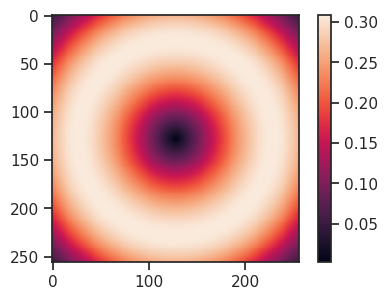

In [61]:
y = whitener(x.cuda())

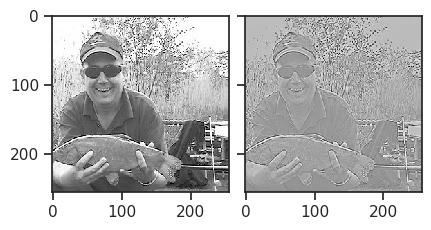

In [62]:
fig, axes = create_figure(1, 2, (4.2, 2.2), 'all', 'all', layout='constrained')

i = 6
axes[0].imshow(to_np(x[i, 0]), cmap='Greys_r')
axes[1].imshow(to_np(y[i, 0]), cmap='Greys_r')
plt.show()

In [118]:
x, y = next(iter(vld))
x.shape

torch.Size([128, 1, 256, 256])

In [123]:
img_f = torch.fft.fft2(x)

phase = torch.angle(img_f)
amplitude = torch.abs(img_f)
power_spectrum = amplitude ** 2
power_spectrum_shifted = torch.fft.fftshift(
    power_spectrum, dim=(-2, -1))

img_f.shape

torch.Size([128, 1, 256, 256])

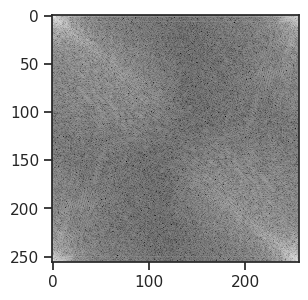

In [124]:
plt.imshow(to_np(torch.log(power_spectrum[10, 0])), cmap='Greys_r')
plt.show()

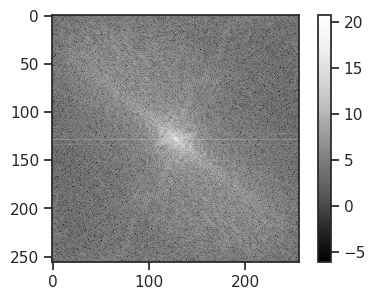

In [129]:
plt.imshow(to_np(torch.log(power_spectrum_shifted[10, 0])), cmap='Greys_r')
plt.colorbar()
plt.show()

In [141]:
freqs = torch.fft.fftfreq(256)
freqs = freqs.reshape(-1, 1) @ freqs.reshape(1, -1)
freqs = torch.fft.fftshift(freqs)

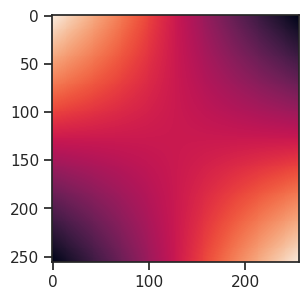

In [142]:
plt.imshow(to_np(freqs))

In [148]:
H, W = 256, 256  # Example dimensions; replace with actual image dimensions

FreqCompRows = np.fft.fftfreq(H,d=2)
FreqCompCols = np.fft.fftfreq(W,d=2)

# Compute the 1D frequency arrays for each dimension
fy = np.fft.fftfreq(H)
fx = np.fft.fftfreq(W)

# Create a 2D grid of frequencies by taking the outer product
freq_array = np.sqrt(np.outer(fy**2, np.ones(W)) + np.outer(np.ones(H), fx**2))

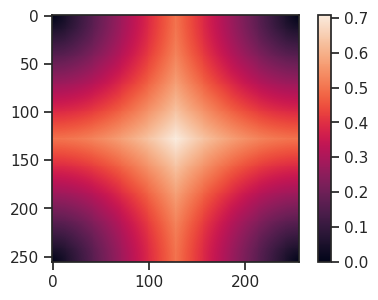

In [147]:
plt.imshow(freq_array)
plt.colorbar()
plt.show()

In [130]:
h, w = avg_power_spectrum.shape
yy, xx = np.ogrid[-h//2:h//2, -w//2:w//2]
radius = np.sqrt(xx**2 + yy**2)
radius = np.fft.fftshift(radius)
radius[radius == 0] = 1

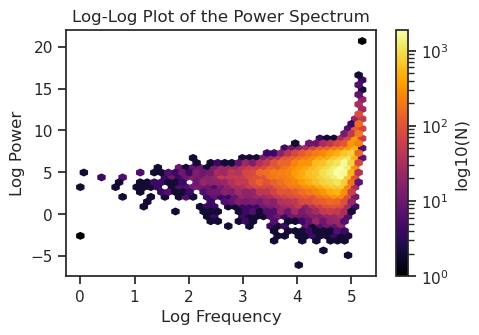

In [131]:
log_freq = np.log(radius)
log_power = np.log(to_np(power_spectrum_shifted[10, 0]))

# Step 4: Plot
plt.hexbin(log_freq.ravel(), log_power.ravel(), gridsize=40, cmap='inferno', bins='log')
plt.colorbar(label='log10(N)')
plt.xlabel('Log Frequency')
plt.ylabel('Log Power')
plt.title('Log-Log Plot of the Power Spectrum')
plt.show()

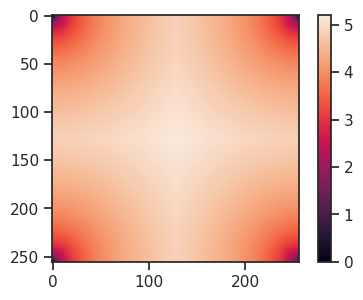

In [134]:
plt.imshow(log_freq)
plt.colorbar()

In [100]:
avg_power_spectrum = power_spectrum_shifted.mean(dim=0).squeeze().numpy()

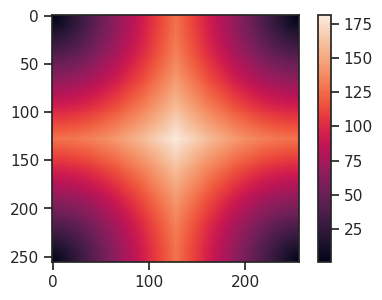

In [128]:
plt.imshow(radius)
plt.colorbar()

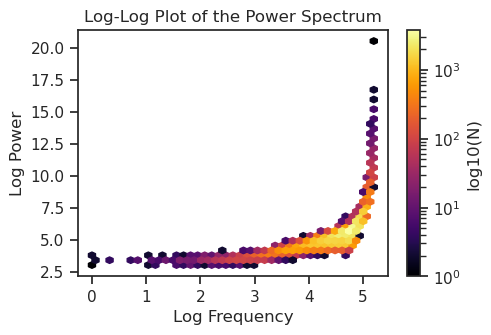

In [99]:
log_freq = np.log(radius)
log_power = np.log(avg_power_spectrum)

# Step 4: Plot
plt.hexbin(log_freq.ravel(), log_power.ravel(), gridsize=40, cmap='inferno', bins='log')
plt.colorbar(label='log10(N)')
plt.xlabel('Log Frequency')
plt.ylabel('Log Power')
plt.title('Log-Log Plot of the Power Spectrum')
plt.show()

In [ ]:
import torch
import matplotlib.pyplot as plt

# For the sake of example, let's create a batch of random images
# In practice, you would replace this with your actual batch of images
batch_size, H, W = 8, 256, 256


# Apply the 2D FFT over the batch of images
x_fft = torch.fft.fft2(x)

# Shift the zero frequency component to the center
x_fft_shifted = torch.fft.fftshift(x_fft, dim=(-2, -1))

# Compute the power spectrum (magnitude squared of the FFT components)
power_spectrum = torch.abs(x_fft_shifted)**2

# Average the power spectrum across the batch
avg_power_spectrum = power_spectrum.mean(dim=0).squeeze()

# Compute the 2D frequency grid
freq_y = torch.fft.fftfreq(H) * H
freq_x = torch.fft.fftfreq(W) * W
freq_y = freq_y.reshape(H, 1)
freq_x = freq_x.reshape(1, W)
radius = torch.sqrt(freq_y**2 + freq_x**2)
radius = torch.fft.fftshift(radius)  # Shift the zero freq to the center

# Avoid division by zero
radius[radius == 0] = 1

# Calculate the indices for the frequency bins
indices = torch.floor(radius).int()

# Sum the power spectrum within each bin
tally = torch.zeros_like(avg_power_spectrum)
for i in range(H):
    for j in range(W):
        tally[indices[i, j]] += avg_power_spectrum[i, j]

# Count the number of elements within each bin to compute the average
counts = torch.zeros_like(avg_power_spectrum)
for value in indices.unique():
    counts[value] = (indices == value).sum()

# Avoid division by zero in the average
counts[counts == 0] = 1

# Compute the radial average of the power spectrum
radial_avg_power_spectrum = tally / counts

# Convert the radial average to a 1D array for plotting
radial_avg_power_spectrum_1d = radial_avg_power_spectrum[radius.unique().int()]

# Get corresponding frequencies for plotting
frequencies = radius.unique()

# Remove zero frequency to avoid log(0) issues
nonzero_indices = frequencies != 0
frequencies = frequencies[nonzero_indices]
radial_avg_power_spectrum_1d = radial_avg_power_spectrum_1d[nonzero_indices]

# Log-log plot
plt.loglog(frequencies.numpy(), radial_avg_power_spectrum_1d.numpy())
plt.xlabel('Frequency')
plt.ylabel('Average Power')
plt.title('Log-Log plot of the


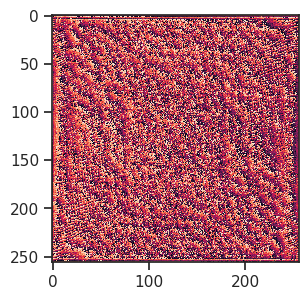

In [76]:
plt.imshow(to_np(phase[76, 0]));

In [ ]:
2

## Doves dataset

In [152]:
from torch.utils.data import Dataset



class GenericDataset(Dataset):
    '''
    Generic Dataset can be used to create a quick pytorch dataset from a dictionary of tensors
    
    Inputs:
        Data: Dictionary of tensors. Each key will be a covariate for the dataset.
    '''
    def __init__(self,
        data):

        self.covariates = data
        self.requested_covariates = list(self.covariates.keys())

    def to(self, device):
        self.covariates = utils.to_device(self.covariates, device)
        return self
        
    def __len__(self):

        return self.covariates['stim'].shape[0]

    def __getitem__(self, index):
        return {cov: self.covariates[cov][index,...] for cov in self.requested_covariates}



class EyeDataset(GenericDataset):
    def __init__(self,nTraj,nImg,gridH,gridW,trajs,imgs):
        data = self.build(nTraj,nImg,gridH,gridW,trajs,imgs)
        super().__init__(data)
        
    def grid_sample(self,traj,img,tlim,gridH,gridW):                    # samples one image using a single eye trace
        im_center = [img.shape[3]/2.0, img.shape[2]/2.0]
        dx = torch.linspace(-1,1,int(gridW))
        dy = torch.linspace(-1,1,int(gridH))
        meshy, meshx = torch.meshgrid(dy, dx)
        grid = torch.stack((meshx, meshy), 2)           # create the grid
        
        img_sample = torch.zeros(tlim,1,gridW,gridH)
        for i in range(tlim):
            grid_center = torch.Tensor([traj[i,0],traj[i,1]])
            
            # Shift and scale the grid (width x height)
            W = (grid_center[0] - im_center[0])/im_center[0]
            H = (grid_center[1] - im_center[1])/im_center[1]

            G = grid/15
            G[..., 0] += W
            G[..., 1] += H

            sample = F.grid_sample(img, G.unsqueeze(0), align_corners=False)
            img_sample[i,:,:,:] = sample
        return img_sample
        
    def build(self,nTraj,nImg,gridH,gridW,trajs,imgs):
        tlim = trajs.shape[1]       # double check this
        
        stim = []
        eyepos = []
        image = []
        ds = []
        
        iTrajs = random.sample(range(0,trajs.shape[0]), nTraj)      # get random indices for eye trajectories
        iImgs  = random.sample(range(0,imgs.shape[0]), nImg)        # same for images
        
        for t in iTrajs:
            for i in iImgs:
                traj = trajs[t,:,:]
                img  = imgs[i,:,:,:].unsqueeze(0)
                
                stim.append(self.grid_sample(traj, img, tlim, gridH, gridW))
                eyepos.append(traj)
                image.append(img)
                
        ds = {
            "stim": torch.stack(stim, dim=0),
            "eyepos": torch.stack(eyepos, dim=0),
            "image": torch.stack(image, dim = 0)
        }

        return ds  

In [159]:
path = pjoin(os.environ['HOME'], 'Datasets/DOVES')

with h5py.File(pjoin(path, 'data1024.h5'), 'r') as f:         
    trajs = f['eye_traces'][()].T

with h5py.File(pjoin(path, 'vHimgs.h5'), 'r') as f:          
    imgs = f['imgs'][()].T

trajs = torch.Tensor(trajs)                     # [N, T, 2]
imgs = torch.Tensor(imgs).unsqueeze(1)          # [B, C, H, W]

In [160]:
imgs.shape

torch.Size([101, 1, 768, 1024])

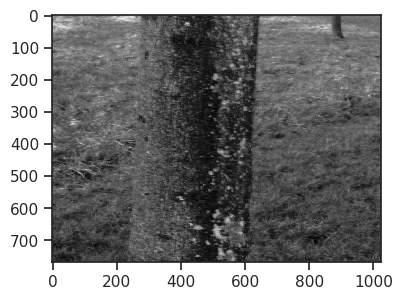

In [168]:
plt.imshow(to_np(imgs[44, 0]), cmap='Greys_r');

In [170]:
import torch.nn.functional as F

In [220]:
#%%
##### Testing the code~ 
nTraj = 5
nImg = 4
gridH = 32
gridW = 32

make_data = EyeDataset(nTraj,nImg,gridH,gridW,trajs,imgs)
data = make_data.build(nTraj,nImg,gridH,gridW,trajs,imgs)

In [221]:
list(data)

['stim', 'eyepos', 'image']

In [222]:
data['stim'].shape

torch.Size([20, 1024, 1, 32, 32])

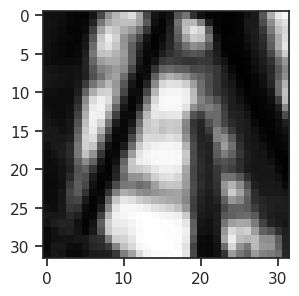

In [236]:
plt.imshow(to_np(data['stim'].squeeze()[16, 200]), cmap='Greys_r');

In [12]:
vars(trn)

{'dataset': Dataset ImageNet
     Number of datapoints: 1281167
     Root location: /home/hadi/Datasets/ImageNet
     Split: train
     StandardTransform
 Transform: ToTensor(),
 'num_workers': 0,
 'prefetch_factor': None,
 'pin_memory': False,
 'pin_memory_device': '',
 'timeout': 0,
 'worker_init_fn': None,
 '_DataLoader__multiprocessing_context': None,
 '_dataset_kind': 0,
 'batch_size': 512,
 'drop_last': False,
 'sampler': <torch.utils.data.sampler.RandomSampler at 0x7f2acfa52b50>,
 'batch_sampler': <torch.utils.data.sampler.BatchSampler at 0x7f2af010ba90>,
 'generator': None,
 'collate_fn': <function torch.utils.data._utils.collate.default_collate(batch)>,
 'persistent_workers': False,
 '_DataLoader__initialized': True,
 '_IterableDataset_len_called': None,
 '_iterator': None}

In [20]:
x = next(iter(trn))

RuntimeError: stack expects each tensor to be equal size, but got [3, 375, 500] at entry 0 and [3, 400, 500] at entry 1

In [ ]:
x

## u: normal, r(u): ?

In [2]:
rng = get_rng()

def r(u, bias=0.0, scale=1.0):
    x = (u - bias) / scale
    return np.log(1 + np.exp(x))

In [3]:
num = 100000
u = rng.normal(size=num)

### Plot hists

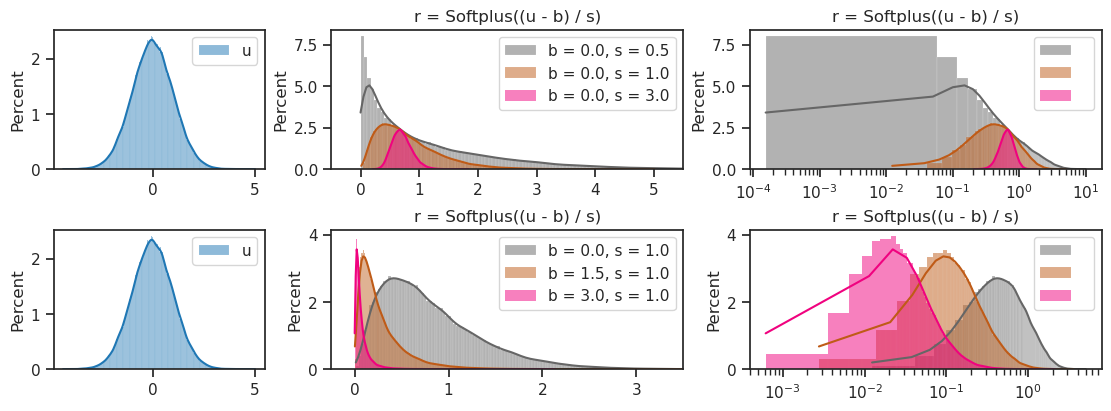

In [4]:
fig, axes = create_figure(2, 3, (11, 4), sharey='none', layout='constrained', width_ratios=[1.2, 2, 2])
for ax in axes[:, 0]:
    sns.histplot(u, stat='percent', kde=True, label='u', ax=ax)

b = 0.0
for i, s in enumerate([0.5, 1.0, 3.0], start=1):
    for j, ax in enumerate(axes[0, 1:]):
        sns.histplot(
            r(u, b, s), color=sns.color_palette('Accent')[8 - i],
            stat='percent', kde=True,
            label=f'b = {b}, s = {s}' if j == 0 else ' ',
            ax=ax)
        ax.set_title('r = Softplus((u - b) / s)')

s = 1.0
for i, b in enumerate([0.0, 1.5, 3.0], start=1):
    for j, ax in enumerate(axes[1, 1:]):
        sns.histplot(
            r(u, b, s), color=sns.color_palette('Accent')[8 - i],
            stat='percent', kde=True,
            label=f'b = {b}, s = {s}' if j == 0 else ' ',
            ax=ax)
        ax.set_title('r = Softplus((u - b) / s)')

axes[0, 1].set_xlim(right=5.5)
axes[1, 1].set_xlim(right=3.5)

for ax in axes[:, -1]:
    ax.set_xscale('log')

for ax in axes.flat:
    ax.legend()
plt.show()

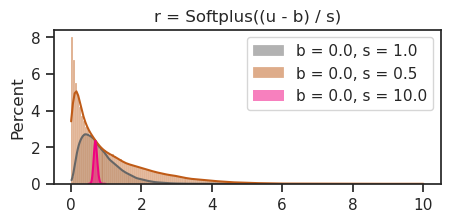

In [11]:
fig, ax = create_figure(1, 1, (5, 2))

b = 0.0
for i, s in enumerate([1.0, 0.5, 10.0], start=1):
    sns.histplot(
        r(u, b, s), color=sns.color_palette('Accent')[8 - i],
        stat='percent', kde=True,
        label=f'b = {b}, s = {s}',
        ax=ax)
    ax.set_title('r = Softplus((u - b) / s)')
ax.legend()
plt.show()

## Poisson reparam

In [12]:
import torch

def differentiable_poisson(rate):
    """
    Differentiable Poisson sampling using the reparameterization trick.
    
    Args:
        rate (Tensor): The rate parameter of the Poisson distribution.
    
    Returns:
        Tensor: Samples from the Poisson distribution.
    """
    eps = torch.rand_like(rate)
    gamma_samples = -rate * torch.log(eps)
    poisson_samples = torch.floor(gamma_samples)
    return poisson_samples

In [16]:
rate = torch.tensor(np.array([[3, 90, 8, 4], [0, 1, 49, 157]]), dtype=torch.float)
rate

tensor([[  3.,  90.,   8.,   4.],
        [  0.,   1.,  49., 157.]])

In [17]:
torch.poisson(rate)

tensor([[  5.,  91.,   7.,   5.],
        [  0.,   2.,  41., 165.]])

In [39]:
differentiable_poisson(rate)

tensor([[  3., 243.,   6.,   0.],
        [  0.,   1.,  96.,  23.]])

In [20]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import gamma


def differentiable_poisson(rate):
    """
    Differentiable Poisson sampling using the reparameterization trick.
    
    Args:
        rate (Tensor): The rate parameter of the Poisson distribution.
    
    Returns:
        Tensor: Samples from the Poisson distribution.
    """
    eps = torch.rand_like(rate)
    gamma_samples = -rate * torch.log(eps)
    poisson_samples = torch.floor(gamma_samples)
    return poisson_samples

# Simulation parameters
rate = 6.6  # Poisson rate
num_samples = 100000  # Number of samples to draw

# Draw samples from the differentiable Poisson implementation
samples = differentiable_poisson(torch.tensor([rate] * num_samples))
samples = samples.numpy()  # Convert to numpy array

# Compute the empirical distribution
unique_values, counts = np.unique(samples, return_counts=True)
empirical_pmf = counts / num_samples

# Compute the theoretical Poisson PMF
theoretical_pmf = np.exp(-rate) * np.power(rate, unique_values) / gamma(unique_values + 1)

/tmp/ipykernel_2895197/2855479878.py:35: RuntimeWarning: overflow encountered in power
  theoretical_pmf = np.exp(-rate) * np.power(rate, unique_values) / gamma(unique_values + 1)
/tmp/ipykernel_2895197/2855479878.py:35: RuntimeWarning: invalid value encountered in divide
  theoretical_pmf = np.exp(-rate) * np.power(rate, unique_values) / gamma(unique_values + 1)


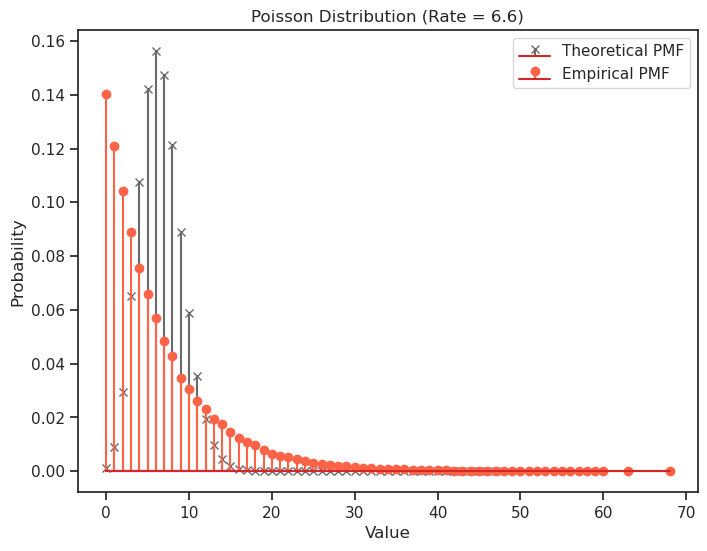

In [18]:
# Plot the empirical and theoretical PMFs
plt.figure(figsize=(8, 6))
plt.stem(unique_values, theoretical_pmf, 'dimgrey', markerfmt='x', label='Theoretical PMF')
plt.stem(unique_values, empirical_pmf, 'tomato', markerfmt='o', label='Empirical PMF')
plt.title(f'Poisson Distribution (Rate = {rate})')
plt.xlabel('Value')
plt.ylabel('Probability')
plt.legend()
plt.show()

In [22]:
import torch
import torch.nn.functional as F

def sample_gumbel(shape, device, eps=1e-20):
    """
    Sample from the Gumbel distribution.
    
    Args:
        shape (tuple): The shape of the Gumbel samples.
        device (torch.device): The device on which to generate the samples.
        eps (float): A small constant to ensure numerical stability.
    
    Returns:
        Tensor: Gumbel samples.
    """
    u = torch.rand(shape, device=device)
    return -torch.log(-torch.log(u + eps) + eps)

def gumbel_softmax_poisson(rate, temperature, eps=1e-20):
    """
    Continuous relaxation of the Poisson distribution using the Gumbel-Softmax (Concrete) distribution.
    
    Args:
        rate (Tensor): The rate parameter of the Poisson distribution.
        temperature (float): The temperature parameter for the Gumbel-Softmax distribution.
        eps (float): A small constant to ensure numerical stability.
    
    Returns:
        Tensor: Continuous samples from the Gumbel-Softmax relaxation of the Poisson distribution.
    """
    rate = rate.clamp(min=eps)  # Ensure rate is non-negative
    log_rate = torch.log(rate + eps)
    
    gumbel_samples = sample_gumbel(rate.size(), rate.device, eps)
    samples = (log_rate + gumbel_samples) / temperature
    concrete_samples = F.softmax(samples, dim=-1)
    
    return concrete_samples

# Example usage
rate = torch.tensor([2.0, 3.0, 1.5, 40, 100])
temperature = 0.5  # Temperature parameter for the Gumbel-Softmax distribution
continuous_samples = gumbel_softmax_poisson(rate, temperature)
print(continuous_samples)

tensor([3.0736e-05, 2.7150e-05, 3.3698e-05, 6.5884e-01, 3.4107e-01])

In [33]:
# Example usage
rate = torch.tensor([2.0, 3.0, 1.5, 40, 100])
temperature = 0.5  # Temperature parameter for the Gumbel-Softmax distribution
continuous_samples = gumbel_softmax_poisson(rate, temperature)
print(continuous_samples)

tensor([1.1211e-04, 7.7653e-05, 1.2743e-06, 1.8576e-03, 9.9795e-01])

## Setup data

In [2]:
import torchvision
from torch.utils.data import DataLoader

batch_size = 512
device = torch.device('cuda:1')

kws = dict(
    root=pjoin(os.environ['HOME'], 'Datasets'),
    transform=torchvision.transforms.ToTensor(),
    download=True,
)
trn = torchvision.datasets.MNIST(train=True, **kws)
vld = torchvision.datasets.MNIST(train=False, **kws)

trn = DataLoader(dataset=trn, batch_size=batch_size, shuffle=True)
vld = DataLoader(dataset=vld, batch_size=batch_size, shuffle=False)

trn.dataset.data.shape, vld.dataset.data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [4]:
gvae = GaussianVAE()

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
| GaussianVAE |  7.8 Mil   |
|     ---     |    ---     |
|     enc     |  6.6 Mil   |
|     dec     |  1.2 Mil   |
+-------------+------------+

In [10]:
z, x_recon, q = gvae(x)
z.shape, x_recon.shape

(torch.Size([512, 2]), torch.Size([512, 1, 28, 28]))

<Axes: ylabel='Count'>

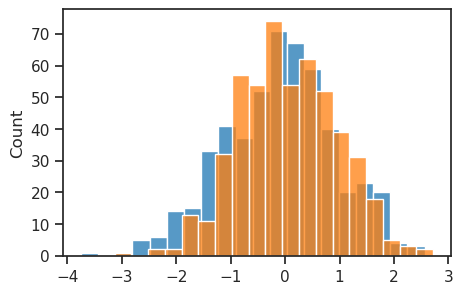

In [20]:
sns.histplot(to_np(z)[:, 0])
sns.histplot(to_np(z)[:, 1])

In [21]:
loss = gvae.compute_loss(q, x_recon, x)
loss

{'kl': tensor(12.8098, device='cuda:1', grad_fn=<SumBackward0>),
 'recon': tensor(300446.0938, device='cuda:1', grad_fn=<MseLossBackward0>),
 'tot': tensor(300446.0938, device='cuda:1', grad_fn=<AddBackward0>)}

In [22]:
kl_1 = residual_kl(q.mu, q.sigma, torch.ones_like(q.sigma))
torch.sum(kl_1)

tensor(12.8098, device='cuda:1', grad_fn=<SumBackward0>)

In [23]:
p = Normal(q.mu.mul(0.0), q.sigma.mul(0.0))
kl_2 = q.kl(p)
torch.sum(kl_2)

tensor(12.8098, device='cuda:1', grad_fn=<SumBackward0>)

In [24]:
np.abs(to_np(kl_1 - kl_2)).mean()

1.8368155e-08

## Train

In [6]:
gvae = GaussianVAE().to(device)

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
| GaussianVAE |  7.8 Mil   |
|     ---     |    ---     |
|     enc     |  6.6 Mil   |
|     dec     |  1.2 Mil   |
+-------------+------------+

In [7]:
lr = 1e-2
epochs = 1000
warmup_portion = 0.0125
warm_restart = 0

n_iters = epochs * len(trn)
n_iters_warmup = int(np.round(
    n_iters * warmup_portion))

# optimizer
kws = dict(
    params=filter(
        lambda p: p.requires_grad,
        gvae.parameters()),
    lr=lr,
    betas=[0.9, 0.999],
    weight_decay=0.0003,
    eps=1e-08,
)
optim = Adamax(**kws)

# scheduler
period = epochs * (1 - warmup_portion)
period /= (2 * warm_restart + 1)

kws = {
    'T_max': period,
    'eta_min': 1e-5,
}
optim_schedule = torch.optim.lr_scheduler.CosineAnnealingLR(optim, **kws)

In [8]:
beta_values = beta_anneal_linear(
    n_iters=n_iters,
    beta=1.0,
    anneal_portion=0.3,
    constant_portion=1e-2,
    min_beta=1e-4,
)

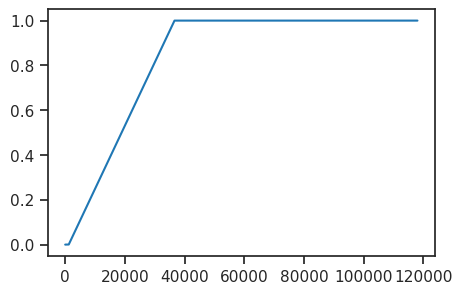

In [9]:
plt.plot(beta_values);

In [10]:
def iteration(model, epoch):
    model.train()
    nelbo = AvgrageMeter()
    for i, (x, _) in enumerate(trn):
        gstep = epoch * len(trn) + i
        # warm-up lr
        if gstep < n_iters_warmup:
            _lr = lr * gstep / n_iters_warmup
            for param_group in optim.param_groups:
                param_group['lr'] = _lr
        # send to device
        if x.device != device:
            x = x.to(device)
        # zero grad
        optim.zero_grad(set_to_none=True)
        # forward
        z, x_recon, q = model(x)
        # update beta + compute loss
        model.update_beta(beta_values[gstep])
        loss_dict = model.compute_loss(q, x_recon, x)
        loss = loss_dict['tot'] / batch_size
        
        # backward + step + scheduler
        loss.backward()
        optim.step()
        cond_schedule = (
            gstep > n_iters_warmup and
            optim_schedule is not None
        )
        if cond_schedule:
            optim_schedule.step()

        # update average meters
        nelbo.update(loss.item())

    return nelbo.avg

In [11]:
pbar = tqdm(range(epochs))
for ep in pbar:
    loss = iteration(gvae, ep)
    msg = ' . . . '.join([
        f"epoch # {ep:03d}",
        f"loss = {loss:0.2f}",
    ])
    pbar.set_description(msg)

epoch # 999 . . . loss = 33.07: 100%|█████| 1000/1000 [2:12:26<00:00,  7.95s/it]


In [37]:
def validate(model):
    model.eval()

    emb, labels = [], []
    loss_vld = collections.defaultdict(list)

    for x, lbl in iter(vld):
        _x = x.to(device)
        with torch.inference_mode():
            mu, _ = model.enc(_x)
            z, x_recon, q = model(_x)
            loss_dict = gvae.compute_loss(q, x_recon, _x)
        emb.append(to_np(mu))
        labels.append(to_np(lbl))
    
        for k, v in loss_dict.items():
            loss_vld[k].append(v.item() / batch_size)

    emb = np.concatenate(emb)
    labels = np.concatenate(labels)
    
    loss_vld = {
        k: np.mean(v) for k, v
        in loss_vld.items()
    }
    return emb, labels, loss_vld

In [36]:
emb, labels, loss_vld = validate(gvae)
loss_vld

{'kl': 5.646238708496094,
 'recon': 27.576580238342284,
 'tot': 33.222818565368655}

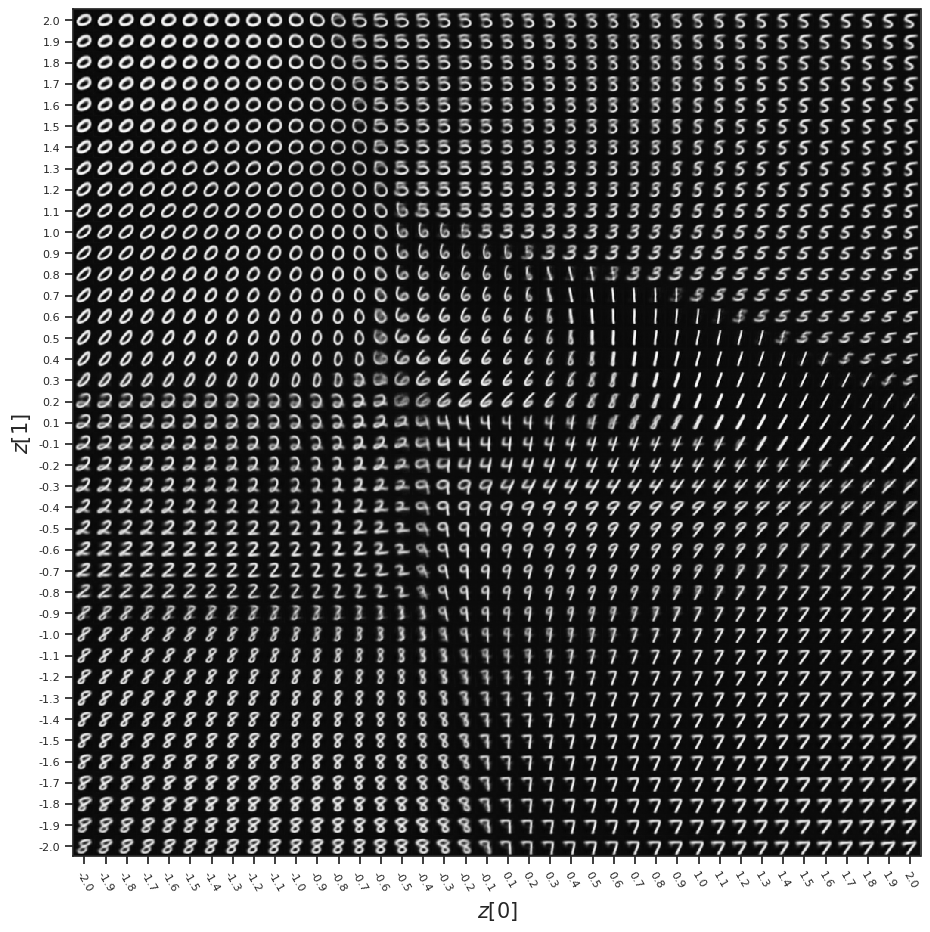

In [33]:
_ = plot_latent_space(gvae.dec, 2.0, 40)

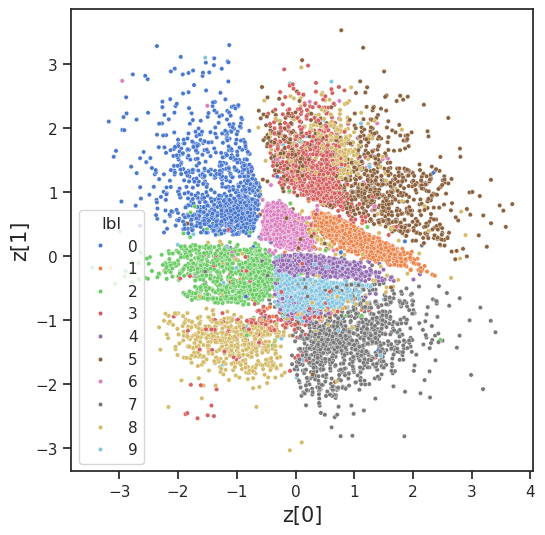

In [34]:
_ = plot_latent_scatter(emb, labels, (6, 6), 10)